In [2]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


In [4]:
import utils_generic as generic
import multitask_simple as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']

In [5]:
model_conf = confs.bert_conf

# Datos ConvAI

In [6]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,tasks,model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,tasks,model_conf) 

In [8]:
convai_train_dataset = mt.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset(md_data,tasks,model_conf) 
md_dataset = mt.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [11]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

## SGD

In [11]:
model = mt.MultiTaskSimple(model_conf).to(device)
save_path='m1_bert_multi'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5, 'as': 0.5071707953063885, 'about': 0.49362244897959184}
Accuracy evaluando en etiquetas female
{'to': 0.06036745406824147, 'as': 0.07547169811320754, 'about': 0.07}
Accuracy evaluando en etiquetas male
{'to': 0.9075425790754258, 'as': 0.9116161616161617, 'about': 0.9348958333333334}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0792603226904256 	 Validation loss: 2.076592065520206 	 
  1%|          | 574/57400 [01:23<2:08:21,  7.38it/s]
Epoch 2 	 Training loss: 2.064993056270719 	 Validation loss: 2.062073505530923 	 
  2%|▏         | 1148/57400 [02:48<2:15:46,  6.90it/s]
Epoch 3 	 Training loss: 2.0451181040823667 	 Validation loss: 2.0313145043486256 	 
  3%|▎         | 1722/57400 [04:13<1:59:16,  7.78it/s]
Epoch 4 	 Training loss: 2.016648127434561 	 Validation loss: 2.0129350060123508 	 
  4%|▍         | 2296/57400 [05:37<2:05:24,  7.32it/s]
Epoch 5 	 Training loss: 1.999811537589761 	 Validation loss: 1.9974227194058694 	 
  5%|▌         | 2870/57400 [07:01<2:09:35,  7.01it/s]
Epoch 6 	 Training loss: 1.99265161727779 	 Validation loss: 1.9974948491080333 	 
  6%|▌         | 3444/57400 [08:27<2:00:11,  7.48it/s]
Epoch 7 	 Training loss: 1.9866648183467082 	 Validation loss: 1.9914141246827983 	 
  7%|▋         | 4018/57400 [09:54<2:08:31,  6.92it/s]
Epoch 8 	 Training loss: 1.9

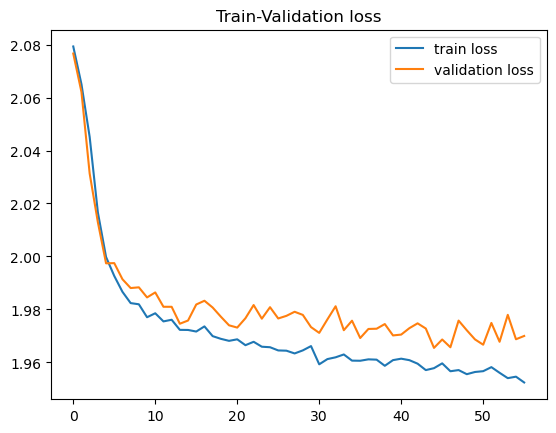

In [13]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [14]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.7058080808080808, 'as': 0.7444589308996089, 'about': 0.8507653061224489}
Accuracy evaluando en etiquetas female
{'to': 0.7086614173228346, 'as': 0.7654986522911051, 'about': 0.865}
Accuracy evaluando en etiquetas male
{'to': 0.7031630170316302, 'as': 0.7247474747474747, 'about': 0.8359375}


## AdamW

In [12]:
model = mt.MultiTaskSimple(model_conf).to(device)
save_path='m1_bert_multi_adamW'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.1080343091944784 	 Validation loss: 2.0826136217278948 	 
  1%|          | 574/57400 [01:37<2:39:33,  5.94it/s]
Epoch 2 	 Training loss: 2.07943141252737 	 Validation loss: 2.0881049633026123 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:13<2:28:18,  6.32it/s]
Epoch 3 	 Training loss: 2.0779026593065426 	 Validation loss: 2.0812389163647667 	 
  3%|▎         | 1722/57400 [04:50<2:30:53,  6.15it/s]
Epoch 4 	 Training loss: 2.0765600308308616 	 Validation loss: 2.0794335825968595 	 
  4%|▍         | 2296/57400 [06:26<2:49:39,  5.41it/s]
Epoch 5 	 Training loss: 2.076820541341961 	 Validation loss: 2.0796392408467956 	 
  5%|▌         | 2870/57400 [08:02<2:24:49,  6.28it/s]
Epoch 6 	 Training loss: 2.076510706014334 	 Validation loss: 2.082412012552811 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:39<2:25:41,  6.17it/s]
Epoch 7 	 Training loss: 2.0764200188972395 	 Validation loss: 2.0833435624332752 	 

2 epoch without improv

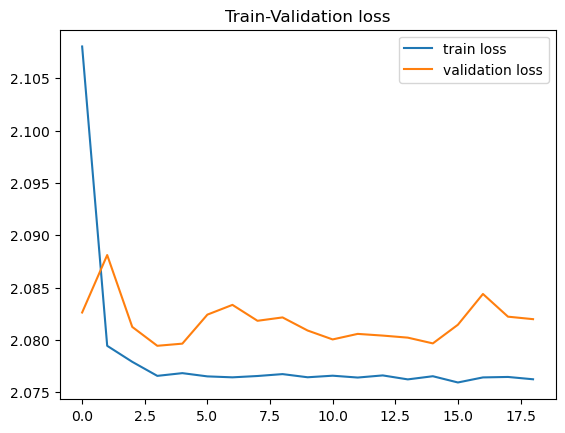

In [16]:
learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [13]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.5189393939393939, 'as': 0.516297262059974, 'about': 0.4897959183673469}
Accuracy evaluando en etiquetas female
{'to': 0.0, 'as': 0.0, 'about': 0.0}
Accuracy evaluando en etiquetas male
{'to': 1.0, 'as': 1.0, 'about': 1.0}
